In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
import struct
from array import array
import numpy as np
from os.path  import join

### Loading MNIST dataset and showing a few training and test examples

In [21]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels

    # To make input images padded to 32*32
    def pad_images(self, images):
        padded_images = []
        for img in images:
            padded_img = np.pad(img, ((2, 2), (2, 2)), mode='constant')
            padded_images.append(padded_img)
        return padded_images
    
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        
        x_train_padded = self.pad_images(x_train)
        x_test_padded = self.pad_images(x_test)
        
        return (x_train_padded, y_train), (x_test_padded, y_test)     

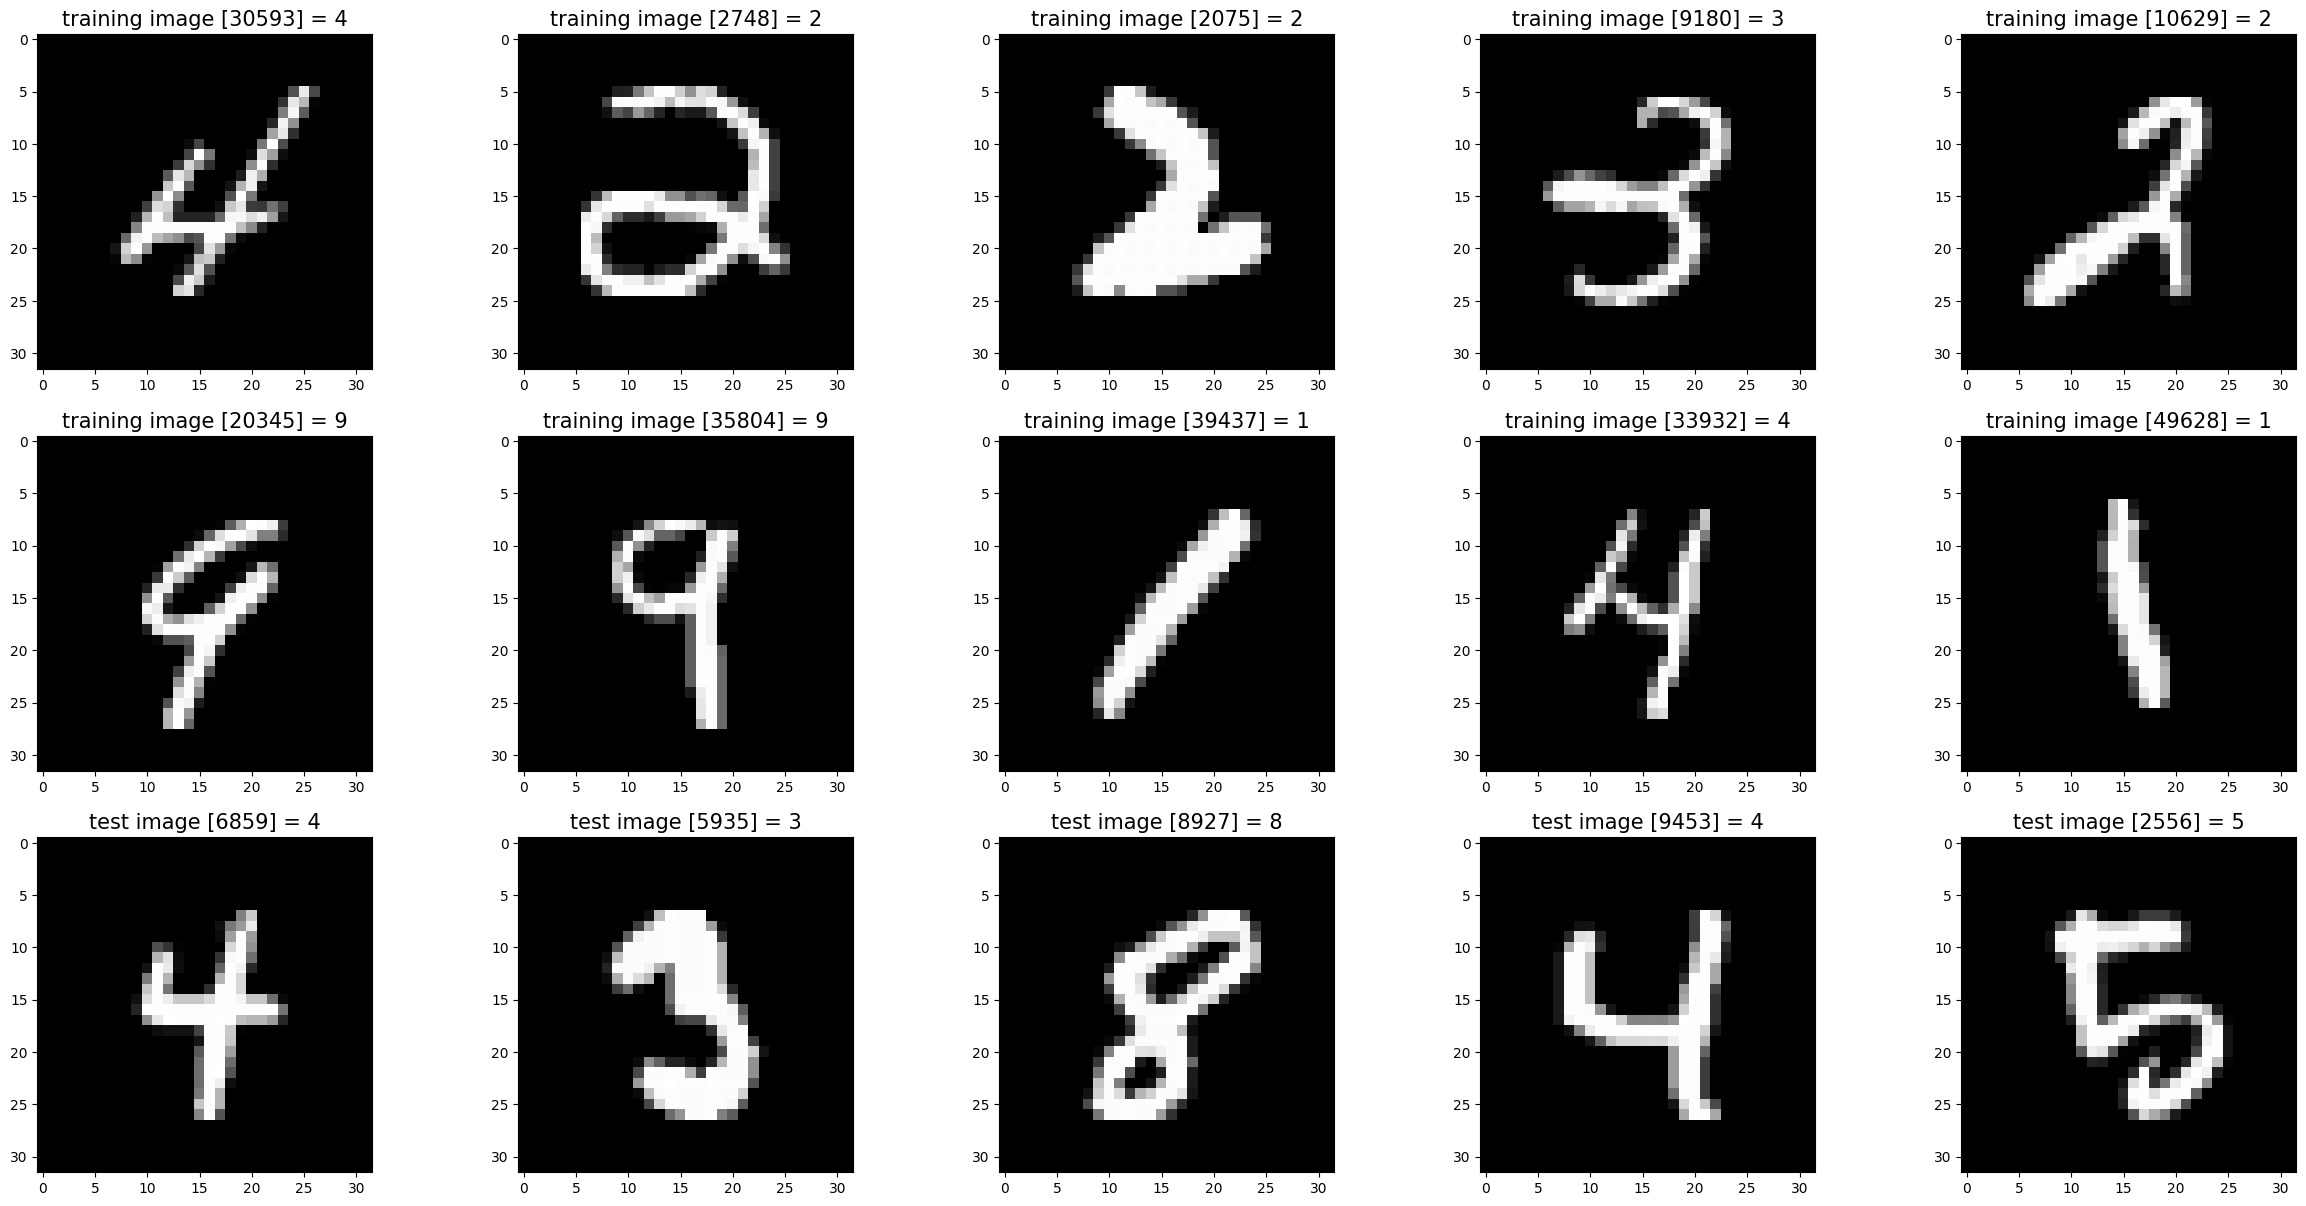

In [22]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = './archive'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

x_train = np.expand_dims(x_train, axis=-1)  # Shape: (60000, 32, 32, 1)
x_test = np.expand_dims(x_test, axis=-1)  # Shape: (10000, 32, 32, 1)

# Preprocessing by noormalizing between [0, 255] insteaed of [0,1]
x_train, x_test = x_train/255.0, x_test/255.0

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

# plt.imshow(x_train[0], cmap='gray')
# plt.show()

show_images(images_2_show, titles_2_show)

### Splitting training data to validation and train dataset

In [23]:
# Define the validation split ratio (e.g., 10% for validation)
validation_split = 0.1

# Calculate the number of samples for validation
num_val_samples = int(validation_split * len(x_train))

# Split the data into training and validation sets
x_val = x_train[-num_val_samples:]
y_val = y_train[-num_val_samples:]
x_train = x_train[:-num_val_samples]
y_train = y_train[:-num_val_samples]

# Print the shapes of the datasets to verify the split
print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)

x_train shape: (54000, 32, 32, 1)
x_val shape: (6000, 32, 32, 1)


## LeNet-5 Model Implementation

In [ ]:
class LeNetModel(tf.Module):
    def __init__(self, num_classes):
        self.conv1_W = tf.Variable(tf.random.normal(shape=(5, 5, 1, 6), mean=0.0, stddev=1.0))
        self.conv1_b = tf.Variable(tf.zeros(6))
        self.conv2_W = tf.Variable(tf.random.normal(shape=(5, 5, 6, 16), mean=0.0, stddev=1.0))
        self.conv2_b = tf.Variable(tf.zeros(16))
        self.fc1_W = tf.Variable(tf.random.normal(shape=(400, 120), mean=0.0, stddev=1.0))
        self.fc1_b = tf.Variable(tf.zeros(120))
        self.fc2_W = tf.Variable(tf.random.normal(shape=(120, 84), mean=0.0, stddev=1.0))
        self.fc2_b = tf.Variable(tf.zeros(84))
        self.fc3_W = tf.Variable(tf.random.normal(shape=(84, num_classes), mean=0.0, stddev=1.0))
        self.fc3_b = tf.Variable(tf.zeros(num_classes))

    def __call__(self, x):
        # Layer 1: Convolutional
        conv1 = tf.nn.conv2d(x, self.conv1_W, strides=[1, 1, 1, 1], padding='VALID') + self.conv1_b
        conv1 = tf.nn.relu(conv1)
        # Average pooling (2,2) -> Input = 28x28x6. Output = 14x14x6.
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

        # Layer 2: Convolutional. Output = 10x10x16.
        conv2 = tf.nn.conv2d(conv1, self.conv2_W, strides=[1, 1, 1, 1], padding='VALID') + self.conv2_b
        conv2 = tf.nn.relu(conv2)
        # Average pooling (2,2) -> Input = 10x10x16. Output = 5x5x16.
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

        # Flatten
        batch_size, height, width, channels = conv2.shape
        flattened_size = height * width * channels
        flattened = tf.reshape(conv2, [batch_size, flattened_size])

        # Layer 3: Fully Connected. Input = (60000,400,1) Output = (60000,120,1)
        fc1 = tf.nn.relu(tf.matmul(flattened, self.fc1_W) + self.fc1_b)

        # Layer 4: Fully Connected. Input = (60000,120,1) Output = (60000,84,1)
        fc2 = tf.nn.relu(tf.matmul(fc1, self.fc2_W) + self.fc2_b)

        # Layer 5: Fully Connected. Input = (60000, 84, 1) Output = (60000, 10, 1)
        logits = tf.matmul(fc2, self.fc3_W) + self.fc3_b
        return logits

num_classes = 10
model = LeNetModel(num_classes)
    
# Set Optimizer: Gradient Descent
learning_rate = 0.001
# optimizer = tf.compat.v1.train.AdamOptimizer(
#     learning_rate=learning_rate,
#     beta1=0.9,
#     beta2=0.999,
#     epsilon=1e-08,
#     use_locking=False,
#     name='Adam'
# )
# optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate, use_locking=False, name='GradientDescent')

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

def compute_loss(logits, labels):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels))

# Training
training_accuracies = []
training_losses = []
validation_accuracies = []

epochs = 15
batch_size = 200

for epoch in range(epochs):
    total_correct_predictions = 0
    total_samples = 0
    
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        with tf.GradientTape() as tape:
            logits = model(x_batch)
            current_loss = compute_loss(logits, y_batch)
        
        gradients = tape.gradient(current_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        # Compute training accuracy for the current batch
        predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
        correct_predictions = tf.reduce_sum(tf.cast(tf.math.argmax(logits, axis=1, output_type=tf.int32) == y_batch, tf.int32))
        total_correct_predictions += correct_predictions
        total_samples += x_batch.shape[0]
    
    # Calculate training accuracy for the epoch
    training_accuracy = total_correct_predictions / total_samples
    training_accuracies.append(training_accuracy)
    training_losses.append(current_loss.numpy())
    
    print(f"Training Accuracy for epoch {epoch + 1}: {training_accuracy.numpy():.4f}")
    print(f"Training Loss for epoch {epoch + 1}: {current_loss.numpy():.4f}")

     # Validation accuracy
    val_logits = model(x_val)
    val_predictions = tf.argmax(val_logits, axis=1, output_type=tf.int32)
    val_accuracy = tf.reduce_mean(tf.cast(tf.equal(val_predictions, y_val), tf.float32))
    validation_accuracies.append(val_accuracy.numpy())

    print(f"Validation Accuracy for epoch {epoch + 1}: {val_accuracy.numpy():.4f}")

Training Accuracy for epoch 1: 0.5315
Training Loss for epoch 1: 1574.3224
Validation Accuracy for epoch 1: 0.7870
Training Accuracy for epoch 2: 0.7952
Training Loss for epoch 2: 805.4781
Validation Accuracy for epoch 2: 0.8590
Training Accuracy for epoch 3: 0.8487
Training Loss for epoch 3: 501.2411
Validation Accuracy for epoch 3: 0.8913
Training Accuracy for epoch 4: 0.8778
Training Loss for epoch 4: 343.8517
Validation Accuracy for epoch 4: 0.9072
Training Accuracy for epoch 5: 0.8964
Training Loss for epoch 5: 262.6237
Validation Accuracy for epoch 5: 0.9168
Training Accuracy for epoch 6: 0.9101
Training Loss for epoch 6: 203.8336
Validation Accuracy for epoch 6: 0.9255
Training Accuracy for epoch 7: 0.9192
Training Loss for epoch 7: 152.3106
Validation Accuracy for epoch 7: 0.9307
Training Accuracy for epoch 8: 0.9280
Training Loss for epoch 8: 124.3763
Validation Accuracy for epoch 8: 0.9368
Training Accuracy for epoch 9: 0.9343
Training Loss for epoch 9: 109.4273
Validation Ac

### Accuracy: Validataion and Test accuracies

In [27]:
# Validation Accuracy
def compute_validation_accuracy(model, x_val, y_val):
    logits = model(x_val)
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, y_val), tf.float32))
    return accuracy.numpy()

# Test Accuracy
def compute_test_accuracy(model, x_test, y_test):
    logits = model(x_test)
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, y_test), tf.float32))
    return accuracy.numpy()

# Measure Validation and Test Accuracies
validation_accuracy = compute_validation_accuracy(model, x_val, y_val)
test_accuracy = compute_test_accuracy(model, x_test, y_test)

print("Validation Accuracy(10% of x_train):", validation_accuracy)
print("Test Accuracy:", test_accuracy)


Validation Accuracy(10% of x_train): 0.953
Test Accuracy: 0.946


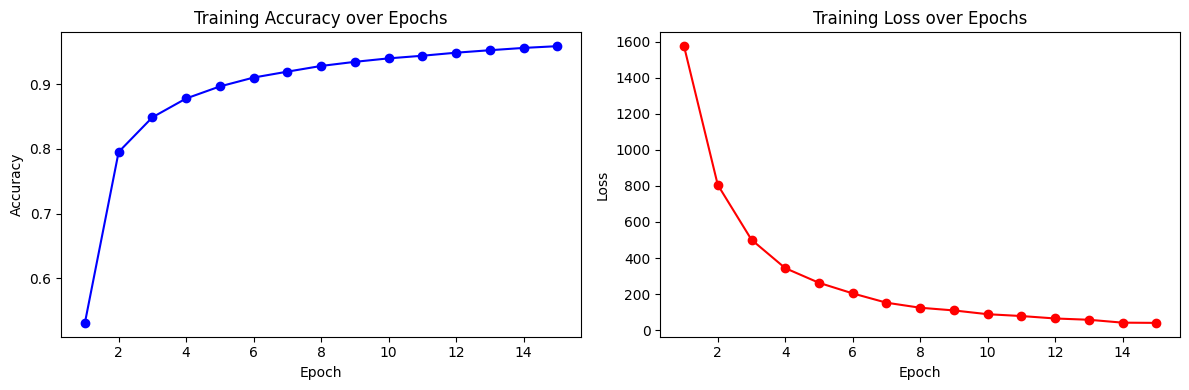

In [28]:
# Plotting training accuracy and loss over epochs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), training_accuracies, marker='o', linestyle='-', color='b')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), training_losses, marker='o', linestyle='-', color='r')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

## References:

1. Reading MNIST dataset: https://www.kaggle.com/code/hojjatk/read-mnist-dataset/notebook
2. To understand architecture in Tensorflow(Professor's recommendation): https://gist.github.com/Moataz-E/6751b1b92fe8f4ff617f10c7f9f9d315
3. Using tf.randon.normal for generating weights: https://www.tensorflow.org/api_docs/python/tf/random/normal
4. Basic training loops: https://www.tensorflow.org/guide/basic_training_loops
5. Understanding of Flatten layer: https://stackoverflow.com/questions/43237124/what-is-the-role-of-flatten-in-keras
6. Adam optimizer: https://www.tensorflow.org/api_docs/python/tf/compat/v1/train/AdamOptimizer